In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Set the random seed and number of samples
np.random.seed(45)
num_samples = 40

# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3 * x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps





1)Use torch.autograd to find the true gradient on the above dataset using linear regression.

Gradient w.r.t. theta1: tensor(0.1922, grad_fn=<ToCopyBackward0>)
Gradient w.r.t. theta0: tensor(0.0448, grad_fn=<ToCopyBackward0>)


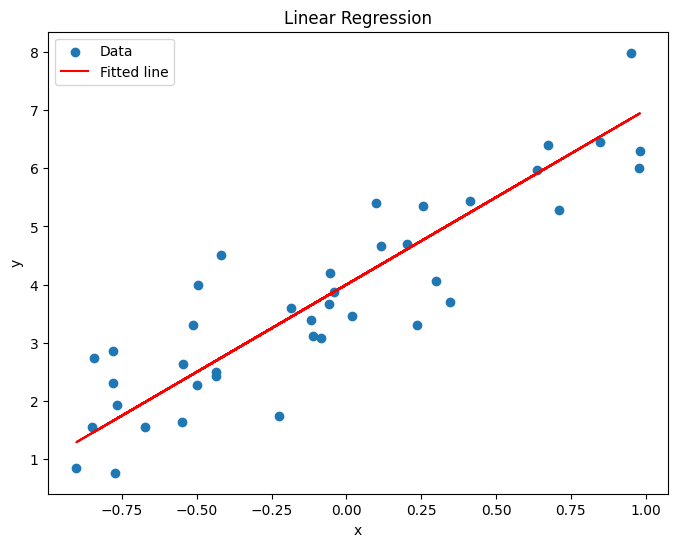

In [2]:
from torch.autograd import grad

x1_t = torch.from_numpy(x1)
y_t = torch.from_numpy(y)

theta0 = torch.tensor(4.0, requires_grad=True)
theta1 = torch.tensor(3.0, requires_grad=True)


y_pred = theta1 * x1_t + theta0


loss = torch.mean((y_pred - y_t) ** 2)

grads = grad(outputs=loss, inputs=[theta1, theta0], create_graph=True)

print("Gradient w.r.t. theta1:", grads[0])
print("Gradient w.r.t. theta0:", grads[1])


plt.figure(figsize=(8, 6))
plt.scatter(x1_t.numpy(), y_t.numpy(), label='Data')  # Scatter plot of the original data
plt.plot(x1_t.numpy(), y_pred.detach().numpy(), color='red', label='Fitted line')  # Line plot of predictions
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.show()




2) Using the same (thetha1,thetha2) as above, calculate the stochastic gradient for all points in the dataset. Then, find the average of all those gradients and show that the stochastic gradient is a good estimate of the true gradient.


In [3]:
thetha0 = torch.tensor(4.0, requires_grad=True)
thetha1 = torch.tensor(3.0, requires_grad=True)

y_pred = thetha0 + x1_t*thetha1

grad_thetha0_list = []
grad_thetha1_list = []
# Since we need to calculate SGD, we need gradient values at each point.

for i in range(num_samples):

    x_i = x1_t[i]
    y_i = y_t[i]

    y_pred_i = thetha0 + x_i*thetha1

    loss = torch.mean((y_pred_i-y_i)**2)

    grads = grad(inputs=[thetha1,thetha0], outputs=loss, create_graph=True)

    grad_thetha0_list.append(grads[1])
    grad_thetha1_list.append(grads[0])

avg_grad_thetha0 = sum(grad_thetha0_list)/num_samples
avg_grad_thetha1 = sum(grad_thetha1_list)/num_samples

print('The average of all Stochastic gradients w.r.t thetha0 is:',avg_grad_thetha0)
print('The average of all Stochastic gradients w.r.t thetha1 is:',avg_grad_thetha1)

The average of all Stochastic gradients w.r.t thetha0 is: tensor(0.0448, grad_fn=<DivBackward0>)
The average of all Stochastic gradients w.r.t thetha1 is: tensor(0.1922, grad_fn=<DivBackward0>)


As we can see above the results of 1.1, the gradient w.r.t thetha0 is 0.0448 and thetha1 is 0.1922.
We get the exact same values thrpugh SGD calculation and averaging all values.
So, SGD is good estimate of true gradient.

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Convert to tensors
x_sample = torch.tensor(x1, dtype=torch.float32)
y_sample = torch.tensor(y, dtype=torch.float32)

# Initialize theta0, theta1 as torch tensors
theta0 = torch.tensor(0.0, requires_grad=True)
theta1 = torch.tensor(0.0, requires_grad=True)

theta0_history = []
theta1_history = []
loss_history = []

def stochastic_gradient(lr, epsilon=0.001, max_epochs=1000):
    global theta0, theta1
    prev_loss = float('inf')
    iteration_count = 0

    for epoch in range(max_epochs):
        # Shuffle the data for stochastic gradient descent
        indices = torch.randperm(len(x_sample))
        for index in indices:
            # Use a single sample for SGD
            x_single = x_sample[index]
            y_single = y_sample[index]

            y_pred = theta1 * x_single + theta0
            loss = (y_pred - y_single) ** 2

            # Compute gradients
            grads = torch.autograd.grad(outputs=loss, inputs=[theta1, theta0])

            # Update parameters
            theta0_new = theta0 - lr * grads[1].detach()
            theta1_new = theta1 - lr * grads[0].detach()

            # Update parameters for the next iteration
            theta0 = theta0_new
            theta1 = theta1_new

            # Increment the iteration counter
            iteration_count += 1

        # Compute and store loss
        y_pred = theta1 * x_sample + theta0
        epoch_loss = torch.mean((y_pred - y_sample) ** 2).item()
        loss_history.append(epoch_loss)

        # Print the loss for the current epoch
        print(f'Epoch {epoch}: Loss = {epoch_loss:.4f}, Iterations = {iteration_count}')

        # Check convergence based on change in loss
        if abs(prev_loss - epoch_loss) < epsilon:
            print(f"Convergence reached after {epoch} epochs and {iteration_count} iterations.")
            return plot_contour_animation()

        # Update previous loss for next iteration
        prev_loss = epoch_loss

        # Store history for plotting
        theta0_history.append(theta0.item())
        theta1_history.append(theta1.item())

    print(f"Reached max epochs. Total iterations: {iteration_count}")
    return plot_contour_animation()

def plot_contour_animation():
    fig, ax = plt.subplots()

    theta0_vals = np.linspace(min(theta0_history) - 2, max(theta0_history) + 2, 100)
    theta1_vals = np.linspace(min(theta1_history) - 2, max(theta1_history) + 2, 100)
    theta0_grid, theta1_grid = np.meshgrid(theta0_vals, theta1_vals)

    # Calculate the loss surface
    def loss_function_grid(theta0, theta1):
        y_pred = theta1 * x_sample + theta0
        return torch.mean((y_pred - y_sample) ** 2).item()

    loss_vals = np.array([[loss_function_grid(t0, t1) for t1 in theta1_vals] for t0 in theta0_vals])

    # Animation function
    def animate(epoch):
        ax.clear()
        ax.contourf(theta0_grid, theta1_grid, loss_vals, levels=50, cmap='viridis')
        ax.plot(theta0_history[:epoch+1], theta1_history[:epoch+1], 'r-o')
        ax.set_title(f'Epoch {epoch}')
        ax.set_xlabel('theta0')
        ax.set_ylabel('theta1')

    anim = FuncAnimation(fig, animate, frames=len(theta0_history), repeat=False)
    plt.close(fig)
    return HTML(anim.to_jshtml())

# Plot loss vs epochs
def plot_loss_vs_epochs(loss_history):
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

stochastic_gradient(lr=0.01)


<ipython-input-16-2bd3c48b74c6>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_sample = torch.tensor(x1, dtype=torch.float32)
<ipython-input-16-2bd3c48b74c6>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_sample = torch.tensor(y, dtype=torch.float32)


Epoch 0: Loss = 0.2300, Iterations = 100
Epoch 1: Loss = 0.1195, Iterations = 200
Epoch 2: Loss = 0.0933, Iterations = 300
Epoch 3: Loss = 0.0734, Iterations = 400
Epoch 4: Loss = 0.0583, Iterations = 500
Epoch 5: Loss = 0.0474, Iterations = 600
Epoch 6: Loss = 0.0379, Iterations = 700
Epoch 7: Loss = 0.0311, Iterations = 800
Epoch 8: Loss = 0.0260, Iterations = 900
Epoch 9: Loss = 0.0224, Iterations = 1000
Epoch 10: Loss = 0.0190, Iterations = 1100
Epoch 11: Loss = 0.0167, Iterations = 1200
Epoch 12: Loss = 0.0150, Iterations = 1300
Epoch 13: Loss = 0.0137, Iterations = 1400
Epoch 14: Loss = 0.0127, Iterations = 1500
Convergence reached after 14 epochs and 1500 iterations.


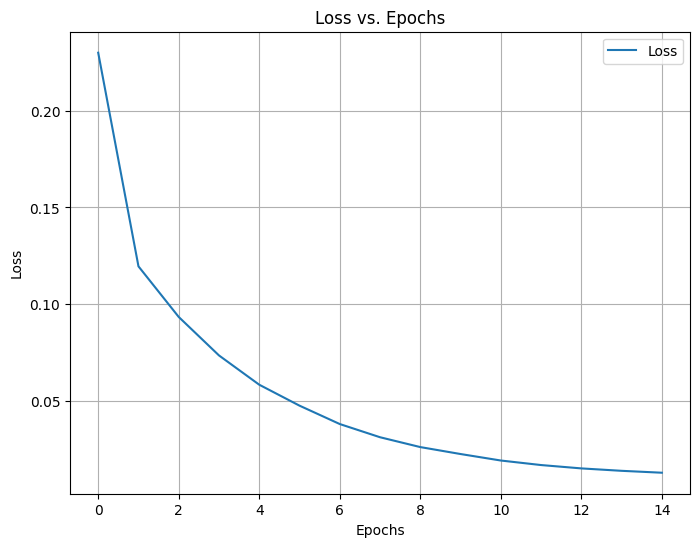

In [17]:
plot_loss_vs_epochs(loss_history)

<ipython-input-31-b2570bb850b6>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_sample = torch.tensor(x1, dtype=torch.float32)
<ipython-input-31-b2570bb850b6>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_sample = torch.tensor(y, dtype=torch.float32)


Convergence reached after 136 epochs and 137 iterations.
Reached max epochs. Total iterations: 137


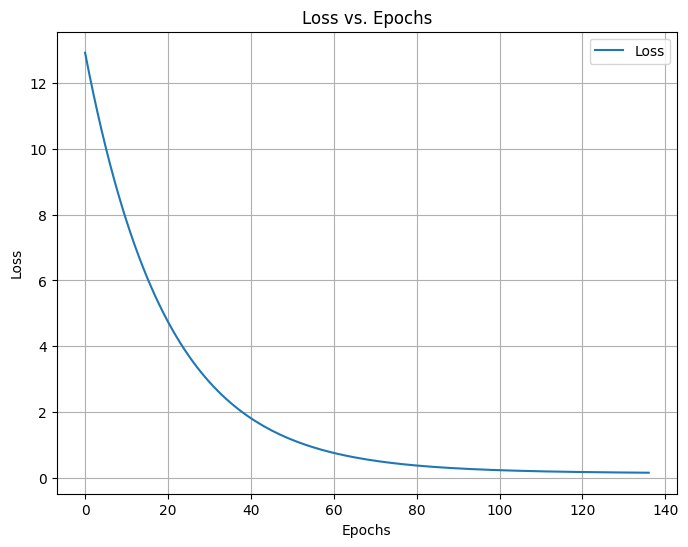

Total number of iterations: 137


In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Initialize theta0 and theta1
theta0 = torch.tensor(0.0, requires_grad=True)
theta1 = torch.tensor(0.0, requires_grad=True)

theta0_history = []
theta1_history = []
loss_history = []

x_sample = torch.tensor(x1, dtype=torch.float32)
y_sample = torch.tensor(y, dtype=torch.float32)

def full_batch_gradient_descent(lr, epsilon=0.001, max_epochs=1000):
    global theta0, theta1
    prev_loss = float('inf')
    iteration_count = 0  # Initialize the iteration counter

    for epoch in range(max_epochs):
        # Compute predictions and loss
        y_pred = theta1 * x_sample + theta0
        loss = torch.mean((y_pred - y_sample) ** 2)

        # Compute gradients
        grads = torch.autograd.grad(outputs=loss, inputs=[theta1, theta0])

        # Update parameters
        theta0_new = theta0 - lr * grads[1].detach()
        theta1_new = theta1 - lr * grads[0].detach()

        # Store history for plotting (detach tensors before storing)
        theta0_history.append(theta0_new.detach().item())
        theta1_history.append(theta1_new.detach().item())
        loss_history.append(loss.item())

        # Increment the iteration counter
        iteration_count += 1

        # Check convergence based on change in loss
        if abs(prev_loss - loss.item()) < epsilon:
            print(f"Convergence reached after {epoch} epochs and {iteration_count} iterations.")
            break

        # Update the current parameters for the next iteration
        theta0 = theta0_new
        theta1 = theta1_new
        prev_loss = loss.item()

    print(f"Reached max epochs. Total iterations: {iteration_count}")
    return theta0_history, theta1_history, loss_history, iteration_count

# Function to compute loss values for a grid of theta0 and theta1
def compute_loss_grid(theta0_vals, theta1_vals):
    loss_vals = np.zeros((len(theta0_vals), len(theta1_vals)))
    for i, t0 in enumerate(theta0_vals):
        for j, t1 in enumerate(theta1_vals):
            # Compute predictions and loss for each pair of theta0 and theta1
            y_pred = t1 * x1 + t0
            loss_vals[i, j] = torch.mean((y_pred - y) ** 2).detach().item()  # Detach before converting to numpy
    return loss_vals

# Function to plot loss vs epochs
def plot_loss_vs_epochs(loss_history):
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

# Animation function to visualize gradient descent
def plot_contour_animation(theta0_vals, theta1_vals):
    # Compute the 2D loss surface
    loss_grid = compute_loss_grid(theta0_vals, theta1_vals)

    fig, ax = plt.subplots()

    # Animation function
    def animate(epoch):
        ax.clear()
        ax.contourf(theta0_vals, theta1_vals, loss_grid, levels=50, cmap='viridis')  # Pass the loss surface
        ax.plot(theta0_history[:epoch+1], theta1_history[:epoch+1], 'r-o')
        ax.set_title(f'Epoch {epoch}')
        ax.set_xlabel('theta0')
        ax.set_ylabel('theta1')

    # Create animation
    anim = FuncAnimation(fig, animate, frames=len(theta0_history), repeat=False)

    plt.close(fig)
    return HTML(anim.to_jshtml())

# Run full-batch gradient descent
theta0_history, theta1_history, loss_history, iterations = full_batch_gradient_descent(lr=0.01)

# Plot loss vs epochs
plot_loss_vs_epochs(loss_history)

# Print the total number of iterations
print(f"Total number of iterations: {iterations}")


In [32]:
theta0_vals = np.linspace(min(theta0_history) - 2, max(theta0_history) + 2, 100)
theta1_vals = np.linspace(min(theta1_history) - 2, max(theta1_history) + 2, 100)

plot_contour_animation(theta0_vals, theta1_vals)

Convergence reached after 62 epochs and 620 iterations.
Reached max epochs: 1000
Total epochs: 62, Total iterations: 620


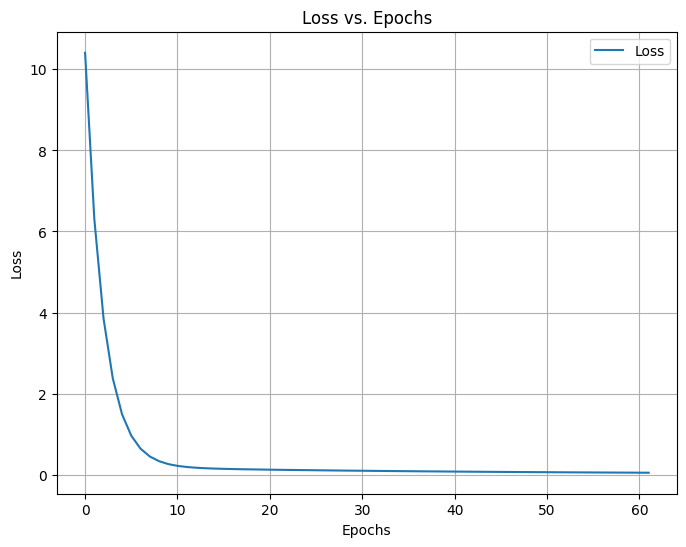

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

theta0 = torch.tensor(0.0, requires_grad=True)
theta1 = torch.tensor(0.0, requires_grad=True)

theta0_history = []
theta1_history = []
loss_history = []

def mini_batch_gradient(lr, batch_size=10, epsilon=0.001, max_epochs=1000):
    global theta0, theta1
    n_samples = len(x1)

    prev_loss = float('inf')
    epoch_count = 0
    iteration_count = 0

    for epoch in range(max_epochs):
        epoch_count += 1
        # Shuffle the data
        indices = torch.randperm(n_samples)
        x1_shuffled = x1[indices]
        y_shuffled = y[indices]

        epoch_loss = 0

        # Iterate through mini-batches
        for i in range(0, n_samples, batch_size):
            iteration_count += 1
            x_batch = x1_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            # Compute predictions and loss
            y_pred = theta1 * x_batch + theta0
            loss = torch.mean((y_pred - y_batch) ** 2)

            # Compute gradients for theta0 and theta1
            grads = torch.autograd.grad(outputs=loss, inputs=[theta1, theta0])

            # Update parameters
            theta0_new = theta0 - lr * grads[1].detach()
            theta1_new = theta1 - lr * grads[0].detach()

            theta0 = theta0_new
            theta1 = theta1_new

            # Accumulate the loss for the epoch
            epoch_loss += loss.item()

        epoch_loss /= (n_samples // batch_size)
        loss_history.append(epoch_loss)  # Track loss history

        # Track the parameter history
        theta0_history.append(theta0.item())
        theta1_history.append(theta1.item())

        # Check convergence
        if abs(prev_loss - epoch_loss) < epsilon:
            print(f"Convergence reached after {epoch_count} epochs and {iteration_count} iterations.")
            break

        # Update previous loss for the next iteration
        prev_loss = epoch_loss

    print(f"Reached max epochs: {max_epochs}")
    print(f"Total epochs: {epoch_count}, Total iterations: {iteration_count}")
    return epoch_count, iteration_count, plot_contour_animation()


def plot_contour_animation():
    fig, ax = plt.subplots()

    theta0_vals = np.linspace(min(theta0_history) - 2, max(theta0_history) + 2, 100)
    theta1_vals = np.linspace(min(theta1_history) - 2, max(theta1_history) + 2, 100)
    theta0_grid, theta1_grid = np.meshgrid(theta0_vals, theta1_vals)

    # Calculate the loss surface
    def loss_function_grid(theta0, theta1):
        y_pred = theta1 * x1 + theta0
        return torch.mean((y_pred - y) ** 2).item()

    loss_vals = np.array([[loss_function_grid(t0, t1) for t1 in theta1_vals] for t0 in theta0_vals])

    # Animation function
    def animate(epoch):
        ax.clear()
        ax.contourf(theta0_grid, theta1_grid, loss_vals, levels=50, cmap='viridis')
        ax.plot(theta0_history[:epoch+1], theta1_history[:epoch+1], 'r-o')
        ax.set_title(f'Epoch {epoch}')
        ax.set_xlabel('theta0')
        ax.set_ylabel('theta1')

    # Create animation
    anim = FuncAnimation(fig, animate, frames=len(theta0_history), repeat=False)
    plt.close(fig)
    return HTML(anim.to_jshtml())

# Plot loss vs epochs
def plot_loss_vs_epochs(loss_history):
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()


epochs, iterations, anim = mini_batch_gradient(lr=0.01, batch_size=10)
plot_loss_vs_epochs(loss_history)
anim


Average number of iterations taken for each type of gradient descent
Full-Batch : 137 ,
Mini_Batch : 614 ,
Stochastic : 1500 .